In [94]:
from numpy import loadtxt, pi
path = loadtxt(r"C:\Users\localadmin.TUD0035314\Documents\GitHub\New_world\robot_trajectory.txt")
poses = []
for i in range(len(path)):
    if path[i][3]!=0:
        if path[i][3] == 1:
            poses.append([path[i][0],path[i][1],path[i-1][2],pi])
        elif path[i][3] == 3:
            poses.append([path[i][0],path[i][1],path[i-1][2],0])
        elif path[i][3] == 2:
            poses.append([path[i][0],path[i][1],path[i-1][2],3*pi/2])
        elif path[i][3] == 4:
            poses.append([path[i][0],path[i][1],path[i-1][2],pi/2])
        
lposes = len(poses)

In [135]:
from math import tan, atan, sqrt, cos, sin
from numpy import eye, diag, array, exp, ceil, floor
from numpy.linalg import inv, det
from random import gauss, randint, uniform
import copy
import sys

class Particle:
    def __init__(self,pose):
        self.pose = pose
        self.landmark_poses = []
        self.landmark_covariances = []
        
    def number_of_landmarks(self):
        return len(self.landmark_poses)
    
    @staticmethod
    def motion(pose, control, WB, dt):  
        angle = (control[1]+pose[2])%(2*pi)
        return ([x+y for x,y in zip(pose,[control[0]*dt*cos(angle),
                                          control[0]*dt*sin(angle),
                                          control[0]*dt*sin(control[1])/WB])])
    
    def move(self,control,WB,dt):
#         self.pose = poses[][0:3]
        print "Lolo",poses[1][0:3]
        self.pose = self.motion(self.pose,control,WB,dt)
        
    def expected_measurement(self,pose,landmark):
        theta = pose[2]
        phi = landmark[2]
        print "Hmm"
        print "Pose is",pose
        print "Lanmdark is",landmark
        print "So"
        
        return tan(phi-theta) # Ratio of the accelerations ax/ay       
    
    def measurement_correspondence(self,pose,measurement,number_of_landmarks,Qt_measurment_covariance):
        likelihoods = []
        for i in range(number_of_landmarks):
            likelihoods.append(self.landmark_correspondence(measurement,i,Qt_measurment_covariance))
        return likelihoods
    
    @staticmethod
    def dh_dlandmark(pose,landmark):
        return array([[1,0,0],[0,1,0],[0,0,-1/(cos(pose[2]-landmark[2])**2)]]) # H - Direct odometry measurement and collision
    
    def H_and_Ql_from_measurement(self,landmark_number,Qt_measurement_covariance):
        
        H = self.dh_dlandmark(self.pose,self.landmark_poses[landmark_number])
        Ql = H * self.landmark_covariances[landmark_number] * H.T + Qt_measurement_covariance
        
        return (H, Ql)
        
    def landmark_correspondence_likelihood(self,measurement,landmark_number,Qt_measurement_covariance):
        # For a given measurment and a landmark number, it returns a suitable likelihood value of the correspondence

        landmark = self.landmark_poses[landmark_number]
        phi = landmark[2]
        theta = self.pose[2]
        
        # Prune the landmark which are not in the robot's frame of collision
        if phi == 90 * floor(theta/90) or phi == 90 * ceil(theta/90): 
            print "Current Pose",self.pose
            print "landmark",landmark
            zhat = self.expected_measurement(self.pose,landmark)
            H, Ql = self.H_and_Ql_from_measurement(landmark_number,Qt_measurement_covariance)
            dz = measurement - zhat
            print "dz is",dz
            print "H is",H
            print "Ql is",Ql
            print "zhat",zhat
            # Compute likelihood
            sqrtdetQl = sqrt(det(Ql))
            print "sqre",sqrtdetQl
            normal = 1 / (2*pi*sqrtdetQl)
            print "normal",normal
            l = exp(-0.5*dz.T*inv(Ql)*dz)
            
        else: 
            print "Dinga"
            l = 0
        
        return l
    
    def initialize_new_landmark(self,measurement,Qt_measurement_covariance):

        self.landmark_poses.append([self.pose[0],self.pose[1],self.pose[2]+atan(measurement)]) # Orientation update as FSM
        # We have to modify the orientation of the landmark to multiples of 90 degrees
        Hinv = array([[1,0,0],[0,1,0],[0,0,1/(1+measurement**2)]])
        Sigma = Hinv*Qt_measurement_covariance*Hinv.T
        # Remember to add the covariance of the particle at that moment
        
        self.landmark_covariances.append(Sigma)
        
    def update_landmark(self,measurment,landmark_number,Qt_measurement_covariance):
        
        mu = self.landmark_poses[landmark_number]
        Sigma = self.landmark_covariances[landmark_number]
        H, Ql = self.H_and_Ql_from_measurement(landmark_number,Qt_measurement_covariance)
        K = Sigma * H.T * inv(Ql)
        
        mu = mu + K*(measurement - self.expected_measurement(mu,Sigma))
        Sigma = (eye(3) - K*H) * Sigma
        
        return (mu,Sigma)
    
    def update_particle(self,measurement,number_of_landmarks,minimum_correspondence_likelihood,Qt_measurement_covariance):

        likelihoods = []
        for i in range(number_of_landmarks):
            likelihoods.append(self.landmark_correspondence_likelihood(measurement,i,Qt_measurement_covariance))
            
        if not likelihoods or max(likelihoods) < minimum_correspondence_likelihood:
            self.initialize_new_landmark(measurement,Qt_measurement_covariance)
            return minimum_correspondence_likelihood
        
        else:
            lmax = max(likelihoods)
            lmax_index = likelihoods.index(lmax)
            mu,Sigma = self.update_landmark(measurement,lmax_index,Qt_measurement_covariance)
            self.landmark_poses[lmax_index] = mu
            self.landmark_covariances[lmax_index] = Sigma
            
            return lmax

class FastSLAM:
    def __init__(self,initial_particles,robot_width,minimum_correspondence_likelihood,measurement_stddev,
                 x_stddev,y_stddev,control_speed_factor,control_head_factor, sample_time):
        # Particles
        self.particles = initial_particles
        
        # Constants
        self.robot_width = robot_width
        self.minimum_correspondence_likelihood = minimum_correspondence_likelihood
        self.xstddev = xstddev
        self.ystddev = ystddev
        self.measurement_stddev = measurement_stddev
        self.control_speed_factor = control_speed_factor
        self.control_head_factor = control_head_factor
        self.dt = sample_time
        self.WB = robot_width
        
    def predict(self,control):
        # Prediction step of FastSLAM

        speed, head = control
        speed_std = self.control_speed_factor * sqrt(speed) # To be modified
        head_std  = self.control_head_factor * sqrt(359 - head) # To be modified; mirror image of the speed deviation
        
        for p in self.particles:
            speed = gauss(speed,speed_std)
            head = gauss(head,head_std)
            p.move([speed,head],self.WB,self.dt)
    
    def update_and_compute_weights(self,measurement):

        Qt_measurement_covariance = diag([self.xstddev ** 2, self.ystddev ** 2,self.measurement_stddev ** 2]) 
        weights = []
        for p in self.particles:
            number_of_landmarks = p.number_of_landmarks()
            weight = p.update_particle(measurement,number_of_landmarks,self.minimum_correspondence_likelihood,
                                            Qt_measurement_covariance)
            weights.append(weight)
            
        return weights
    
    def resample(self,weights):
        
        new_particles = []
        max_weight = max(weights)
        index = randint(0, len(self.particles)-1)
        offset = 0.0
        for i in xrange(len(self.particles)):
            offset += uniform(0, 2.0 * max_weight)
            while offset > weights[index]:
                offset -= weights[index]
                index = (index + 1) % len(weights)
            new_particles.append(copy.deepcopy(self.particles[index]))
            
        return new_particles
    
    def correct(self,measurement):

        weights = self.update_and_compute_weights(measurement)
        self.particles = self.resample(weights)
        
        return weights
        
if __name__ == '__main__':
    
    robot_width = 2
    sample_time = 0.01
    
    minimum_correspondence_likelihood = 1e-3
    xstddev = 10
    ystddev = 10
    measurement_stddev = 100
    
    control_speed_factor = 1
    control_head_factor = 1
    number_of_particles = 100
    
    start_state = poses[0][0:3]
    initial_particles = [copy.copy(Particle(start_state))
                         for _ in xrange(number_of_particles)]

    fs = FastSLAM(initial_particles,robot_width,minimum_correspondence_likelihood,measurement_stddev,xstddev,ystddev,
                 control_speed_factor,control_head_factor, sample_time)
    
    for i in xrange(lposes-1):
        print "Iteration",i
        # Correction step
        w = fs.correct(tan(poses[i][3]-poses[i][2])) # Ratio of acceleration values ax/ay
        #Prediction
        fs.predict([100,poses[i+1][2]])
        
    print "Done"
    print w

Iteration 0
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [251.0, 2.35619449019]
Lolo [25

AttributeError: 'float' object has no attribute 'T'

In [134]:
pose = [111.5, 161.5, 0.78539816339699997]
control = [100,2.35619449019]

def motion(pose, control, WB, dt):  
    angle = (control[1]+pose[2])%(2*pi)
    return ([x+y for x,y in zip(pose,[control[0]*dt*cos(angle),
                                      control[0]*dt*sin(angle),
                                      control[0]*dt*sin(control[1])/WB])])

print motion(pose,control,2,0.6)

[51.5, 161.5000000001676, 21.99860159904317]


In [139]:
print poses[1]

[22.0, 251.0, 2.35619449019, 3.141592653589793]


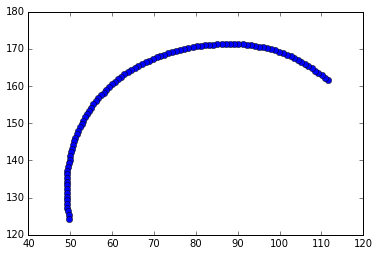

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
from time import sleep
from IPython import display

xl = []
yl = []

for i in xrange(len(fs.particles[4].landmark_poses)):
    xl.append(fs.particles[0].landmark_poses[i][0])
    yl.append(fs.particles[0].landmark_poses[i][1])
#     xl.append(poses[i][0])
#     yl.append(poses[i][1])

plt.plot(xl,yl,'o')
plt.show()